# Experiment description
## Hypothesis: 
Peaks observed on experiment 12 (using FFT approach) are also observed using periodogram and multitaper approach.

## Method: 
Periodogram and multitaper spectral estimation to identify periodicity on time series signals by localidad. Time series to analyze***:

- Localidades with high predictability (P>0.7) and low variance (variance < 0.2): Ciudad Bolívar, Bosa, Usme, San Cristobal, Rafael Uribe Uribe, Suba, Kennedy. 
- Localidades with medium predictability ([0.4, 0.7]) and variance ([0.2, 0.4]): Engativa, Tunjuelito, Fontibon, Usaquen
- Localidades with low predictability (P < 0.4) and high variance (variance > 0.4): Antonio Nariño, Santa Fe, Candelaria, Barrios Unidos y Mártires.

** Localidades that dont fit on former classification: Puente Aranda, Chapinero, Teusaquillo

*** Classification based on predictability results obtained on experiment 08 and variance of experiment 11

## Built-in methods

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import scipy as sp
import scipy.fftpack
from scipy.signal import find_peaks

import nitime.algorithms as tsa
import nitime.utils as utils
from nitime.viz import winspect
from nitime.viz import plot_spectral_estimate

from IPython.display import display, HTML
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [3]:
def set_initial_dataset_day(df_by_date,name_day):
    df_by_date = df_by_date.reset_index()
    df_by_date['day_of_week'] = df_by_date['date'].dt.day_name()
    monday_idx = df_by_date.index[df_by_date['day_of_week'] == name_day].tolist()[0]
    df_by_date = df_by_date[monday_idx:].set_index('date').drop(['day_of_week'],axis=1)
    return df_by_date

In [ ]:
def get_max_frequencies(unilateral_fft_signal,fs_original_signal):
    max_freq = unilateral_fft_signal.argsort()[-10:][::-1]
    print('Max frequencies: ',max_freq)
    periodicity = fs_original_signal/max_freq
    print('Periods: ', periodicity)

In [47]:
def get_frequency_peaks(unilateral_fft, custom_distance):
    peaks, _ = find_peaks(unilateral_fft, distance = custom_distance)
    return peaks

In [ ]:
def get_peaks_magnitude(unilateral_fft, peaks_location_array):
    peaks_magnitude = []
    for peak in peaks_location_array:
        magnitude = round(unilateral_fft[peak],2)
        peaks_magnitude.append(magnitude)
    return peaks_magnitude

In [ ]:
def get_peaks_period(array_frequency_peaks,fs):
    peaks_period = []
    for peak in array_frequency_peaks:
        period = round((fs/peak),2)
        peaks_period.append(period)
    return peaks_period

In [ ]:
def get_periods_by_peak(peaks,n_periods):
    period_values_array = {}
    for period in range(n_periods):
        period_values_array[period]=[]
        for peak in peaks:
            current_period = peaks[peak]['periods'][period]
            period_values_array[period].append(current_period)

    return period_values_array

In [ ]:
def plot_fft_period_axis(signal_time_domain,unilateral_fft):
    fs = len(signal_time_domain)
    samples_fft = len(unilateral_fft)
    inv=unilateral_fft[1:][::-1]
    #inv = low_pass_filter(inv, fc =0.08, b =0.08)
    #samples_inv = len(inv) +1
    points_x = np.arange(samples_fft)
    period = fs/(samples_fft - points_x[1:])
    inv = inv/inv.max()
    
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    ax.plot(period,inv)
    plt.ylabel("Amplitude")
    plt.xlabel("Period (in days)")
    plt.axis([0, 15, 0, 1.2])
    plt.show()
    

In [16]:
def dB(x, out=None):
    if out is None:
        return 10 * np.log10(x)
    else:
        np.log10(x, out)
        np.multiply(out, 10, out)

## Data

In [4]:
data_location = '/Users/anamaria/Desktop/dev/security_project/datasets/06. verify_enrich_nuse_11022020.csv'
df_input = pd.read_csv(data_location,delimiter=",")

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [5]:
df = df_input.copy()

In [6]:
df = df.loc[df['ANIO']!= 2019]
df['date']=pd.to_datetime(df['FECHA']).dt.strftime('%Y-%m-%d')
df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d')
df_by_date = pd.DataFrame(df.groupby(['date','PERIODO_TS','LOCALIDAD']).size(),columns=["total_eventos"])

In [7]:
df_by_date = df_by_date.reset_index().set_index('date')

In [8]:
df_by_date.LOCALIDAD.unique()

array(['ANTONIO NARIÑO', 'BARRIOS UNIDOS', 'BOSA', 'CANDELARIA',
       'CHAPINERO', 'CIUDAD BOLIVAR', 'ENGATIVA', 'FONTIBON', 'KENNEDY',
       'LOS MARTIRES', 'PUENTE ARANDA', 'RAFAEL URIBE URIBE',
       'SAN CRISTOBAL', 'SANTA FE', 'SUBA', 'SUMAPAZ', 'TEUSAQUILLO',
       'TUNJUELITO', 'USAQUEN', 'USME', 'SIN LOCALIZACION'], dtype=object)

In [10]:
## Periodogram experiment

In [9]:
# keep length windows of experiment 11 to set lT
lenWindow = 7
lT=(len(df['date'].unique())//lenWindow)*lenWindow 

In [11]:
df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == 'CIUDAD BOLIVAR']

#Make sure dataset starts on Monday for the experiment
df_by_localidad = set_initial_dataset_day(df_by_localidad,'Monday')

#Make sure dataset include consecutive dates in period
idx = pd.date_range(min(df_by_localidad.reset_index().date), max(df_by_localidad.reset_index().date))
df_by_localidad = df_by_localidad.reindex(idx, fill_value=0)

df_localidad_values = pd.Series(df_by_localidad['total_eventos']).values
df_localidad_values = df_localidad_values[0:lT]

df_localidad_values = df_localidad_values/(df_localidad_values.max())

In [43]:
N = 512
ar_seq, nz, alpha = utils.ar_generator(N=N, drop_transients=10)
ar_seq -= ar_seq.mean()

In [44]:
alpha

array([ 2.7607, -3.8106,  2.6535, -0.9238])

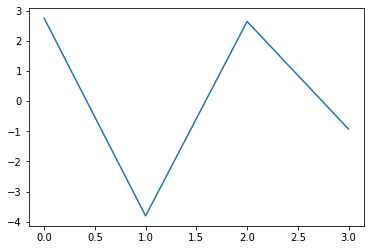

In [45]:
plt.plot(alpha)
plt.show()

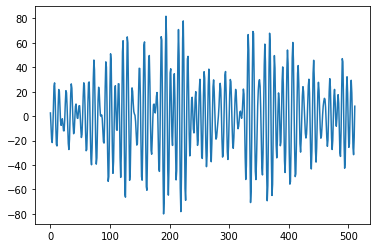

In [36]:
plt.plot(ar_seq)
plt.show()

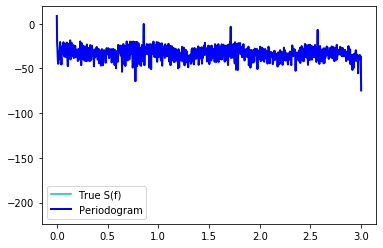

In [22]:
freqs, d_psd = tsa.periodogram(df_localidad_values)
dB(d_psd, d_psd)
fig03 = plot_spectral_estimate(freqs, d_psd, (d_psd,), elabels=("Periodogram",))

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning:

Casting complex values to real discards the imaginary part



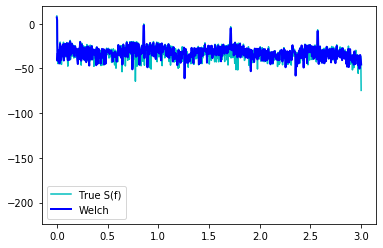

In [26]:
N=len(df_localidad_values)
welch_freqs, welch_psd = tsa.get_spectra(df_localidad_values,method=dict(this_method='welch', NFFT=N))
welch_freqs *= (np.pi / welch_freqs.max())
welch_psd = welch_psd.squeeze()
dB(welch_psd, welch_psd)

fig04 = plot_spectral_estimate(freqs, d_psd, (welch_psd,), elabels=("Welch",))

In [27]:
f, psd_mt, nu = tsa.multi_taper_psd(df_localidad_values, adaptive=False, jackknife=False)
dB(psd_mt, psd_mt)

In [33]:
Kmax = nu[0] / 2
Kmax

7.0

In [31]:
ln2db = dB(np.e)

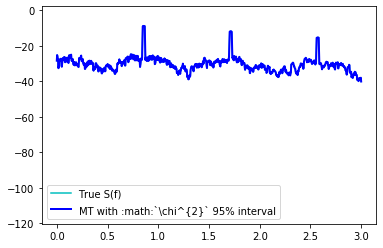

In [83]:
import scipy.stats.distributions as dist

p975 = dist.chi2.ppf(.975, 2 * Kmax)
p025 = dist.chi2.ppf(.025, 2 * Kmax)

l1 = ln2db * np.log(2 * Kmax / p975)
l2 = ln2db * np.log(2 * Kmax / p025)

hyp_limits = (psd_mt + l1, psd_mt + l2)

fig05 = plot_spectral_estimate(freqs, psd_mt, (psd_mt,),elabels=(r"MT with :math:`\chi^{2}` 95% interval",))

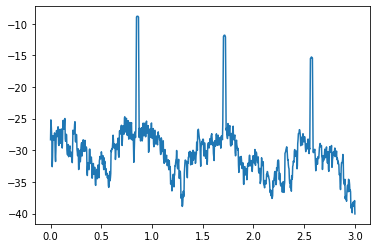

In [84]:
plt.plot(freqs,psd_mt)

In [82]:
get_frequency_peaks(psd_mt, 200)

array([ 43, 261, 521, 780])

In [75]:
import math
print(psd_mt[261], freqs[261], 2*math.pi/freqs[261])
print(psd_mt[521], freqs[521], 2*math.pi/freqs[521])
print(psd_mt[780], freqs[780], 2*math.pi/freqs[780])

-8.82662587018405 0.8604395604395605 7.302297100298114
-11.819273594525917 1.7175824175824175 3.65815651281729
-15.259741644203 2.5714285714285716 2.443460952792061


In [53]:
psd_mt

array([-28.34380396, -25.20494967, -25.95818367, -27.21583497,
       -28.46814148, -32.60064417, -31.09920283, -27.76884371,
       -27.68408592, -27.92302892, -28.11381175, -28.43089824,
       -27.26078602, -27.76230088, -30.91589208, -31.779174  ,
       -30.01711907, -27.49384754, -26.87911957, -27.56953517,
       -27.84977846, -27.75234816, -26.30370757, -26.30897217,
       -29.00800983, -29.24967538, -28.74125432, -26.72167594,
       -26.7736464 , -28.35806095, -28.88821673, -28.25983052,
       -26.65013151, -26.65744684, -29.28120122, -29.65321136,
       -28.23005432, -25.35453669, -25.2819034 , -26.31666852,
       -26.67724283, -26.34569416, -25.11256697, -24.985847  ,
       -28.19974748, -28.59317998, -28.20157119, -27.47701679,
       -27.5639071 , -29.97824817, -30.5497113 , -30.75509141,
       -29.19065819, -29.10101533, -31.02141423, -30.86514516,
       -29.7903681 , -29.69467473, -29.31375364, -30.75230293,
       -31.00463467, -30.49506957, -30.30812562, -30.66

# Results
## Experiment localidades with high predictability and low predictability variance

In [ ]:
localidadesList = ['CIUDAD BOLIVAR','BOSA','USME','SAN CRISTOBAL','RAFAEL URIBE URIBE','SUBA','KENNEDY']

In [ ]:
# keep length windows of experiment 11 to set lT
lenWindow = 7
lT=(len(df['date'].unique())//lenWindow)*lenWindow 

In [ ]:
peaks={}

for localidad in localidadesList:
    df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == localidad]
    
    #Make sure dataset starts on Monday for the experiment
    df_by_localidad = set_initial_dataset_day(df_by_localidad,'Monday')

    #Make sure dataset include consecutive dates in period
    idx = pd.date_range(min(df_by_localidad.reset_index().date), max(df_by_localidad.reset_index().date))
    df_by_localidad = df_by_localidad.reindex(idx, fill_value=0)
    
    df_localidad_values = pd.Series(df_by_localidad['total_eventos']).values
    df_localidad_values = df_localidad_values[0:lT]
    
    df_localidad_values = df_localidad_values/(df_localidad_values.max())
    
    fft_localidad = fourier_analysis(df_localidad_values)
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    ax.plot(fft_localidad[1:])
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency")
    plt.show()
    
    plot_fft_period_axis(df_localidad_values,fft_localidad)
    
    peaks[localidad]={}
    peak_points = get_frequency_peaks(fft_localidad, 90)
    peak_values = get_peaks_magnitude(fft_localidad,peak_points)
    peak_periods = get_peaks_period(list(peak_points),len(df_localidad_values))
    peaks[localidad]['frequency']=list(peak_points)
    peaks[localidad]['periods']=peak_periods
    peaks[localidad]['values']=peak_values   
    print(localidad+': '+str(peaks[localidad]))

## Experiment localidades with medium predictability values and variance

In [ ]:
localidadesList = ['ENGATIVA','TUNJUELITO','FONTIBON','USAQUEN']

In [ ]:
peaks={}

for localidad in localidadesList:
    df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == localidad]
    
    #Make sure dataset starts on Monday for the experiment
    df_by_localidad = set_initial_dataset_day(df_by_localidad,'Monday')

    #Make sure dataset include consecutive dates in period
    idx = pd.date_range(min(df_by_localidad.reset_index().date), max(df_by_localidad.reset_index().date))
    df_by_localidad = df_by_localidad.reindex(idx, fill_value=0)
    
    df_localidad_values = pd.Series(df_by_localidad['total_eventos']).values
    df_localidad_values = df_localidad_values[0:lT]
    
    df_localidad_values = df_localidad_values/(df_localidad_values.max())
    
    fft_localidad = fourier_analysis(df_localidad_values)
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    ax.plot(fft_localidad[1:])
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency")
    plt.show()
    
    plot_fft_period_axis(df_localidad_values,fft_localidad)
    
    peaks[localidad]={}
    peak_points = get_frequency_peaks(fft_localidad, 90)
    peak_values = get_peaks_magnitude(fft_localidad,peak_points)
    peak_periods = get_peaks_period(list(peak_points),len(df_localidad_values))
    peaks[localidad]['frequency']=list(peak_points)
    peaks[localidad]['periods']=peak_periods
    peaks[localidad]['values']=peak_values   
    print(localidad+': '+str(peaks[localidad]))

## Experiment localidades with low predictability values and high predictability variance

In [ ]:
localidadesList = ['ANTONIO NARIÑO','SANTA FE','CANDELARIA','BARRIOS UNIDOS','LOS MARTIRES']

In [ ]:
peaks={}

for localidad in localidadesList:
    df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == localidad]
    
    #Make sure dataset starts on Monday for the experiment
    df_by_localidad = set_initial_dataset_day(df_by_localidad,'Monday')

    #Make sure dataset include consecutive dates in period
    idx = pd.date_range(min(df_by_localidad.reset_index().date), max(df_by_localidad.reset_index().date))
    df_by_localidad = df_by_localidad.reindex(idx, fill_value=0)
    
    df_localidad_values = pd.Series(df_by_localidad['total_eventos']).values
    df_localidad_values = df_localidad_values[0:lT]
    
    df_localidad_values = df_localidad_values/(df_localidad_values.max())
    
    fft_localidad = fourier_analysis(df_localidad_values)
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    ax.plot(fft_localidad[1:])
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency")
    plt.show()
    
    plot_fft_period_axis(df_localidad_values,fft_localidad)
    
    peaks[localidad]={}
    peak_points = get_frequency_peaks(fft_localidad, 90)
    peak_values = get_peaks_magnitude(fft_localidad,peak_points)
    peak_periods = get_peaks_period(list(peak_points),len(df_localidad_values))
    peaks[localidad]['frequency']=list(peak_points)
    peaks[localidad]['periods']=peak_periods
    peaks[localidad]['values']=peak_values   
    print(localidad+': '+str(peaks[localidad]))

## Experiment particular localidades

In [ ]:
localidadesList = ['PUENTE ARANDA','CHAPINERO','TEUSAQUILLO']

In [ ]:
peaks={}

for localidad in localidadesList:
    df_by_localidad = df_by_date[df_by_date['LOCALIDAD'] == localidad]
    
    #Make sure dataset starts on Monday for the experiment
    df_by_localidad = set_initial_dataset_day(df_by_localidad,'Monday')

    #Make sure dataset include consecutive dates in period
    idx = pd.date_range(min(df_by_localidad.reset_index().date), max(df_by_localidad.reset_index().date))
    df_by_localidad = df_by_localidad.reindex(idx, fill_value=0)
    
    df_localidad_values = pd.Series(df_by_localidad['total_eventos']).values
    df_localidad_values = df_localidad_values[0:lT]
    
    df_localidad_values = df_localidad_values/(df_localidad_values.max())
    
    fft_localidad = fourier_analysis(df_localidad_values)
    fig, ax = plt.subplots(1,1,sharex=True, sharey=True)
    ax.plot(fft_localidad[1:])
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency")
    plt.show()
    
    plot_fft_period_axis(df_localidad_values,fft_localidad)
    
    peaks[localidad]={}
    peak_points = get_frequency_peaks(fft_localidad, 90)
    peak_values = get_peaks_magnitude(fft_localidad,peak_points)
    peak_periods = get_peaks_period(list(peak_points),len(df_localidad_values))
    peaks[localidad]['frequency']=list(peak_points)
    peaks[localidad]['periods']=peak_periods
    peaks[localidad]['values']=peak_values   
    print(localidad+': '+str(peaks[localidad]))